# Testing

This is a notebook to test C3A v different CCA methods.

## Imports

In [67]:
import numpy as np
from sklearn.cross_decomposition import CCA
from c3a import C3A, GridSearchC3A
from gemmr.generative_model import GEMMR
from gemmr.estimators import SVDCCA
import matplotlib.pyplot as plt
import scipy.stats 
plt.style.use('ggplot')
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

## Generate data

This generates two matricies with a known canoncial correaltion of around 0.3

In [2]:
model_definition = GEMMR('cca', wx=50, wy=50, r_between=0.3)
behavioural_data_study1, imging_data_study1 = model_definition.generate_data(n=200000)
study1 = (imging_data_study1, behavioural_data_study1) 

## Fit models

In [15]:
cca = CCA(n_components=1)
gmmr_cca = SVDCCA(calc_loadings=True)
c3a_model = C3A(l2=0)
X_sck, Y_sck = cca.fit_transform(behavioural_data_study1, imging_data_study1)
X_gmmr, Y_gmmr = gmmr_cca.fit_transform(behavioural_data_study1, imging_data_study1)
projections = c3a_model.fit_transform(study1)
x_c3a = projections[0][0]
y_c3a = projections[0][1]

## Correlations

In [16]:
gmmr_cor = float(gmmr_cca.corrs_[0])
sklearn_corr = np.corrcoef(X_sck.T, Y_sck.T)[0, 1]
ca3_corr = c3a_model.calculate_canonical_correlations()[0]
print(f"Sckit learn: {sklearn_corr:.3f}")
print(f"GEMMR: {gmmr_cor:.3f}")
print(f"C3A: {ca3_corr:.3f}")

Sckit learn: 0.298
GEMMR: 0.298
C3A: 0.298


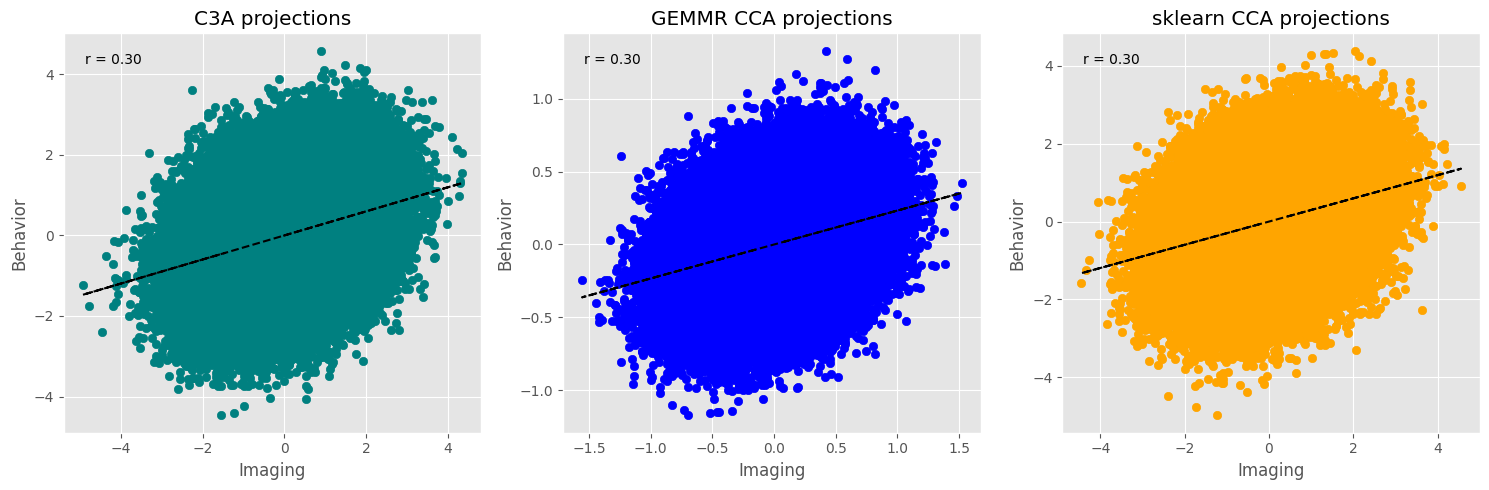

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(x_c3a, y_c3a, c='teal')
m, b = np.polyfit(x_c3a.flatten(), y_c3a.flatten(), 1)
plt.plot(x_c3a, m*x_c3a + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {ca3_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("C3A projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.subplot(1, 3, 2)
plt.scatter(X_gmmr, Y_gmmr, c='blue', label=f"r = {gmmr_cor:.2f}")
m, b = np.polyfit(X_gmmr.flatten(), Y_gmmr.flatten(), 1)
plt.plot(X_gmmr, m*X_gmmr + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {gmmr_cor:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("GEMMR CCA projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.subplot(1, 3, 3)
plt.scatter(X_sck, Y_sck, c='orange', label=f"r = {sklearn_corr:.2f}")
m, b = np.polyfit(X_sck.flatten(), Y_sck.flatten(), 1)
plt.plot(X_sck, m*X_sck + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {sklearn_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("sklearn CCA projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.tight_layout()
plt.show()

In [18]:
display(scipy.stats.ttest_ind(x_c3a.flatten(), X_gmmr.flatten() ))
display(scipy.stats.ttest_ind(y_c3a.flatten(), Y_gmmr.flatten() ))


TtestResult(statistic=np.float64(-1.0465700724434096e-15), pvalue=np.float64(0.9999999999999991), df=np.float64(399998.0))

TtestResult(statistic=np.float64(1.2241333764921823e-15), pvalue=np.float64(0.999999999999999), df=np.float64(399998.0))

## Check loadings

In [19]:
cca1_x = gmmr_cca.x_loadings_.squeeze()
cca2_x = c3a_model.compute_loadings(study1)[0][0]
cca1_y = gmmr_cca.y_loadings_.squeeze()
cca2_y = c3a_model.compute_loadings(study1)[0][1]

### X loadings

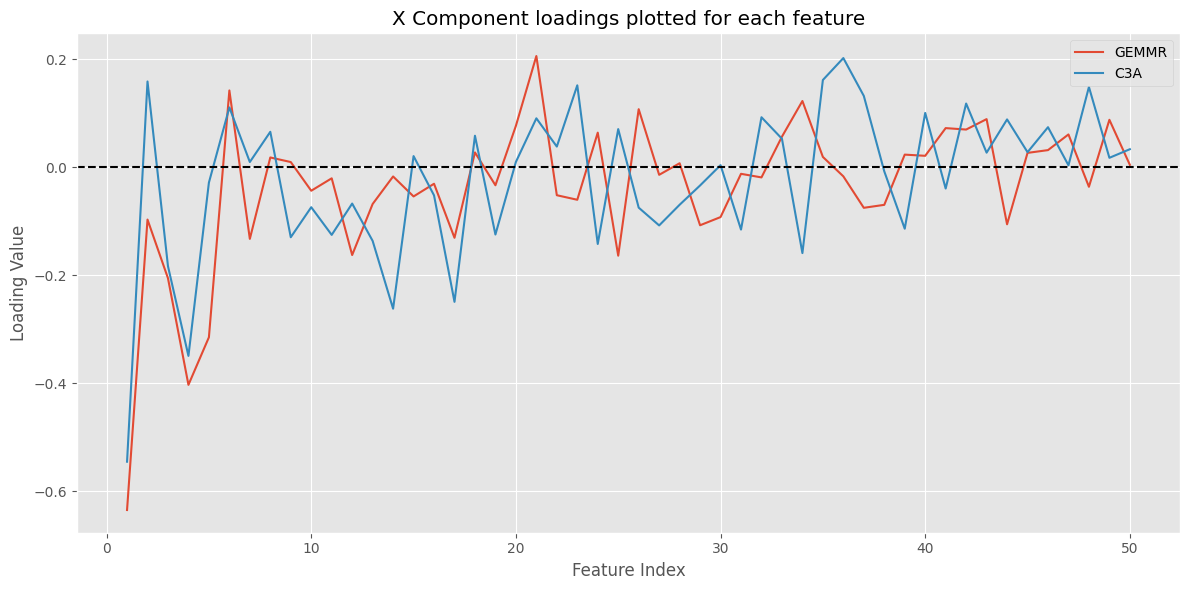

In [20]:
x = np.arange(len(cca1_x)) + 1
plt.figure(figsize=(12, 6))
plt.plot(x, cca1_x, label="GEMMR")
plt.plot(x, cca2_x, label="C3A")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.title("X Component loadings plotted for each feature")
plt.legend()
plt.tight_layout()
plt.show()

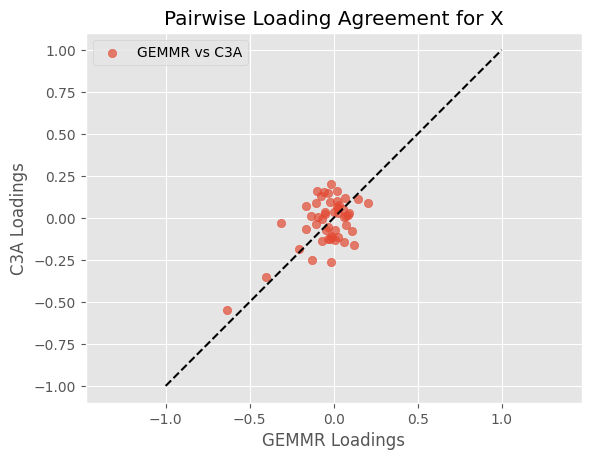

In [21]:
plt.scatter(cca1_x, cca2_x, label="GEMMR vs C3A", alpha=0.7)
plt.plot([-1, 1], [-1, 1], 'k--')  # identity line
plt.xlabel("GEMMR Loadings")
plt.ylabel("C3A Loadings")
plt.legend()
plt.title("Pairwise Loading Agreement for X")
plt.axis('equal')
plt.grid(True)
plt.show()

### Component loadings for Y

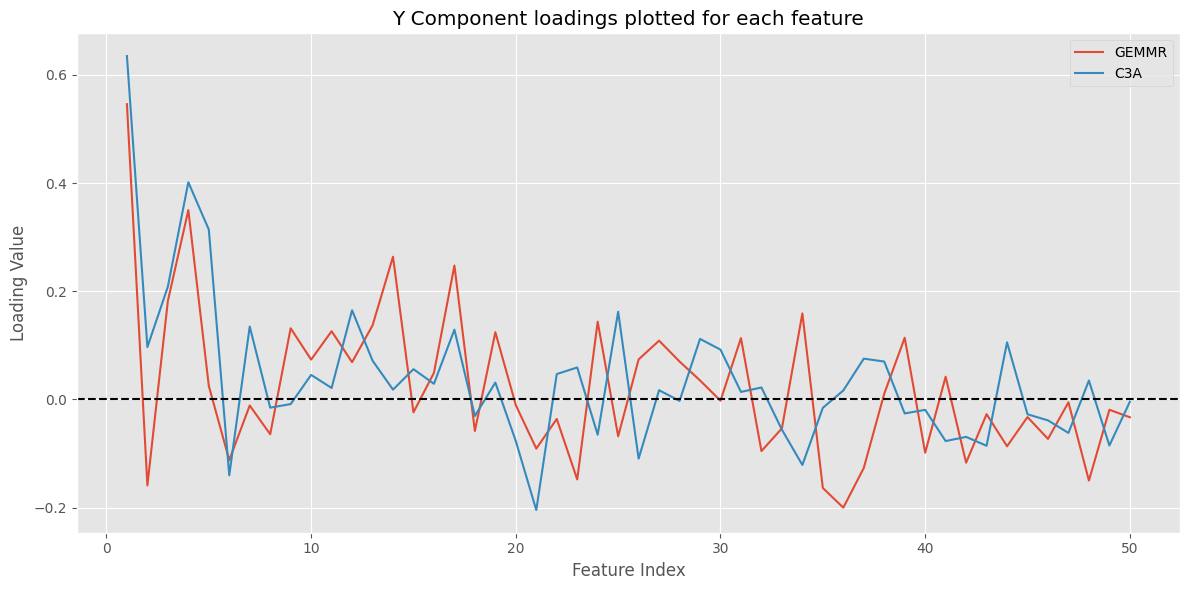

In [22]:
y = np.arange(len(cca1_x)) + 1
plt.figure(figsize=(12, 6))
plt.plot(y, cca1_y, label="GEMMR")
plt.plot(y, cca2_y, label="C3A")
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.title("Y Component loadings plotted for each feature")
plt.legend()
plt.tight_layout()
plt.show()

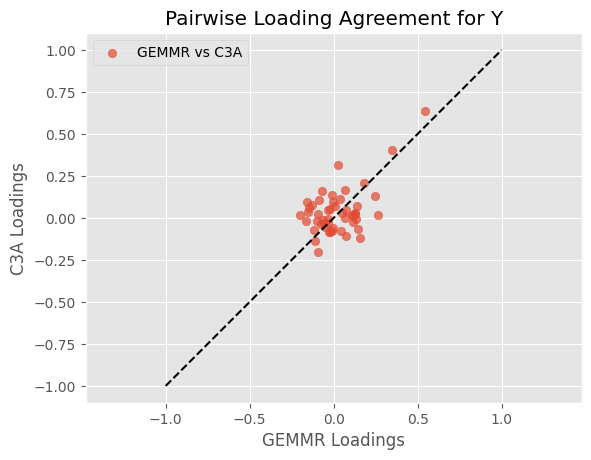

In [23]:
plt.scatter(cca1_y, cca2_y, label="GEMMR vs C3A", alpha=0.7)
plt.plot([-1, 1], [-1, 1], 'k--')  # identity line
plt.xlabel("GEMMR Loadings")
plt.ylabel("C3A Loadings")
plt.legend()
plt.title("Pairwise Loading Agreement for Y")
plt.axis('equal')
plt.grid(True)
plt.show()

## Permuation testing 

In [104]:
def permutation_test():
    model_definition = GEMMR('cca', wx=50, wy=50, r_between=0.3)
    results = {
        "n": [],
        "gmmr_corr": [],
        "c3a_corr": [],
    }

    for n in np.arange(300, 10, -10):  # from 2000 to 200 by step -100
        behavioral_data_study1, imaging_data_study1 = model_definition.generate_data(n=n)
        study1 = (imaging_data_study1, behavioral_data_study1)
        # GEMMR CCA
        try:
            gmmr_cca = SVDCCA(calc_loadings=True)
            gmmr_cca.fit(behavioral_data_study1, imaging_data_study1)
            gmmr_cor = round(float(gmmr_cca.corrs_[0]),2)
        except Exception:
            gmmr_cor = 1.0
        if np.isnan(gmmr_cor):
            gmmr_cor = 1.0
        ## Your C3A model
        c3a_model = C3A(l2=0)
        projections = c3a_model.fit_transform(study1)
        ca3_corr = round(c3a_model.calculate_canonical_correlations()[0], 2)
        # Store results
        results["n"].append(round(n, 2))
        results["gmmr_corr"].append(gmmr_cor)
        results["c3a_corr"].append(ca3_corr)
        print(f"n={n} | GEMMR: {gmmr_cor:.2f}, C3A: {ca3_corr:.2f}")

    return results

# Example usage:
results = permutation_test()

n=300 | GEMMR: 0.71, C3A: 0.59
n=290 | GEMMR: 0.76, C3A: 0.63
n=280 | GEMMR: 0.76, C3A: 0.60
n=270 | GEMMR: 0.76, C3A: 0.65
n=260 | GEMMR: 0.78, C3A: 0.66
n=250 | GEMMR: 0.81, C3A: 0.65
n=240 | GEMMR: 0.82, C3A: 0.62
n=230 | GEMMR: 0.81, C3A: 0.66
n=220 | GEMMR: 0.83, C3A: 0.68
n=210 | GEMMR: 0.84, C3A: 0.68
n=200 | GEMMR: 0.83, C3A: 0.67
n=190 | GEMMR: 0.86, C3A: 0.67
n=180 | GEMMR: 0.89, C3A: 0.66
n=170 | GEMMR: 0.91, C3A: 0.72
n=160 | GEMMR: 0.91, C3A: 0.71
n=150 | GEMMR: 0.94, C3A: 0.72
n=140 | GEMMR: 0.95, C3A: 0.75
n=130 | GEMMR: 0.98, C3A: 0.77
n=120 | GEMMR: 0.98, C3A: 0.76
n=110 | GEMMR: 0.99, C3A: 0.79
n=100 | GEMMR: 1.00, C3A: 0.83
n=90 | GEMMR: 1.00, C3A: 0.82
n=80 | GEMMR: 1.00, C3A: 0.84
n=70 | GEMMR: 1.00, C3A: 0.79
n=60 | GEMMR: 1.00, C3A: 0.82
n=50 | GEMMR: 1.00, C3A: 0.84
n=40 | GEMMR: 1.00, C3A: 0.85
n=30 | GEMMR: 1.00, C3A: 0.94
n=20 | GEMMR: 1.00, C3A: 0.94


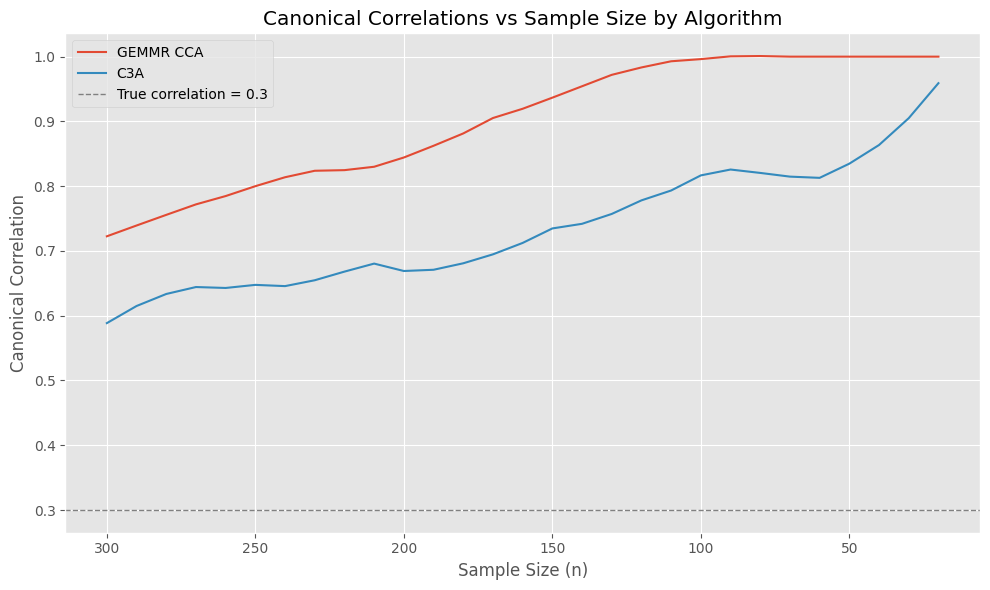

In [105]:

def plot_correlation_results_smooth(results):
    plt.figure(figsize=(10, 6))

    window_length = 7  # must be odd and less than or equal to size of data
    polyorder = 2

    # Smooth each correlation array
    gmmr_smooth = savgol_filter(results["gmmr_corr"], window_length, polyorder)
    c3a_smooth = savgol_filter(results["c3a_corr"], window_length, polyorder)

    plt.plot(results["n"], gmmr_smooth, label="GEMMR CCA", )
    plt.plot(results["n"], c3a_smooth, label="C3A",)

    plt.axhline(y=0.3, color='gray', linestyle='--', linewidth=1, label="True correlation = 0.3")

    plt.xlabel("Sample Size (n)")
    plt.ylabel("Canonical Correlation")
    plt.title("Canonical Correlations vs Sample Size by Algorithm")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()
plot_correlation_results_smooth(results)


## Testing C3A capabilities

In [ ]:
model_definition = GEMMR('cca', wx=10, wy=5, r_between=0.3)
behavioural_data_study1, imging_data_study1 = model_definition.generate_data(n=20000)
behavioural_data_study2, imging_data_study2 = model_definition.generate_data(n=1900)
study1 = (imging_data_study1, behavioural_data_study1) 
study2 = (imging_data_study2, behavioural_data_study2)

In [ ]:
l2_ranges = np.arange(0, 10, 0.1)
search = GridSearchC3A(l2_ranges, verbose=False)
search.fit(study1, study2)
print(search.best_model_)

0.1


In [59]:
across_study = C3A(l2=search.best_l2_, theta=1)
across_study.fit(study1, study2)
transformed = across_study.transform(study1, study2)

In [60]:
x = np.hstack([transformed[0][0], transformed[1][0]])
y = np.hstack([transformed[0][1], transformed[1][1]])

In [61]:
ca3_corr = np.corrcoef(x, y)[0][1]

In [62]:
ca3_corr

np.float64(0.28454276737218853)

Text(0, 0.5, 'Behavior')

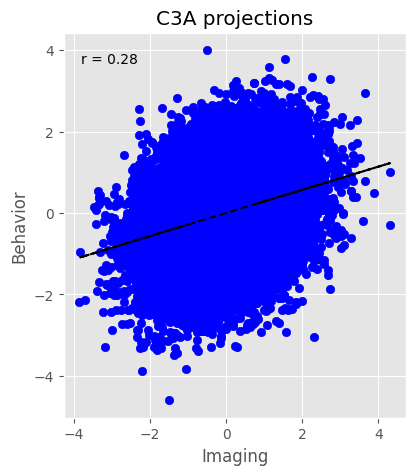

In [63]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(x, y, c='blue')
m, b = np.polyfit(x.flatten(), y.flatten(), 1)
plt.plot(x, m*x + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {ca3_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("C3A projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

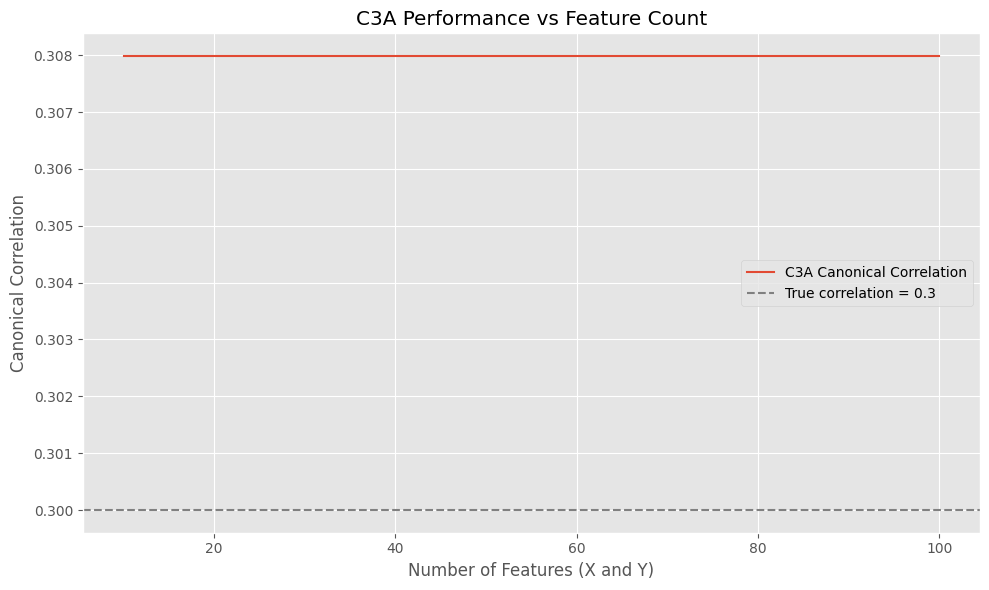

In [115]:
model_definition = GEMMR('cca', wx=100, wy=1, r_between=0.3)
behav1, img1 = model_definition.generate_data(n=20000)
behav2, img2 = model_definition.generate_data(n=1900)

# Feature range
feature_counts = np.arange(100, 1, -10)
correlations = []

for f in feature_counts:
    study1 = (img1[:, :f], behav1)
    study2 = (img2[:, :f], behav2)

    l2_range = np.arange(0, 10, 0.1)
    search = GridSearchC3A(l2_range, verbose=False)
    search.fit(study1, study2)

    model = C3A(l2=search.best_l2_, theta=1)
    model.fit(study1, study2)
    transformed = model.transform(study1, study2)

    x_proj = np.hstack([transformed[0][0], transformed[1][0]])
    y_proj = np.hstack([transformed[0][1], transformed[1][1]])

    corr = np.corrcoef(x_proj, y_proj)[0, 1]
    correlations.append(corr)

# Smooth the results
smoothed_corr = savgol_filter(correlations, window_length=5, polyorder=2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, smoothed_corr, label='C3A Canonical Correlation')
plt.axhline(y=0.3, color='gray', linestyle='--', label='True correlation = 0.3')
plt.xlabel("Number of Features (X and Y)")
plt.ylabel("Canonical Correlation")
plt.title("C3A Performance vs Feature Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()